In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
path_performance = config.path_performance
birth_date = config.birth_date
dico_pen_tr = config.dico_pen_tr
path_extracted_data = config.path_extracted_data
pal_treat = config.pal_treat

In [4]:
path_performance_visual = os.path.join(path_extracted_data, 'OFH_performance')
if not os.path.exists(path_performance_visual):
    os.makedirs(path_performance_visual)

# Download data

In [138]:
#performance
li_df = []
for d in [str(i)+'_4_E420' for i in range(0,12)]:
    print(d)
    for v in ['('+str(i)+')' for i in range(1,21)]:
        xls = pd.ExcelFile(glob.glob(os.path.join(path_performance,d+'.xls*'))[0])
        df = pd.read_excel(xls, v, header=None)
        df = df.iloc[2:,]
        df.columns = df.iloc[0]
        df = df.drop(2, axis=0)
        df = df[~df['Vers.-Tag'].isnull()] #remove all rows that has nothing to do with the egg per day
        df['LayingPhase'] = d
        df['Pen'] = int(v[1:-1])
        if df.shape[0]!=28:
            print('ERROR: ', d, v,' have wrong shape', df.shape)
        if df.shape[1]!=15:
            print('ERROR: ', d, v,' have wrong shape', df.shape)
        df.head(2)
        li_df.append(df)
        df_test = pd.concat(li_df)
df = pd.concat(li_df)

#egg
df['Nest-eier'].fillna(0,inplace=True)
df['Tier-bestand'].fillna(0,inplace=True)
df['ver-legt'].fillna(0,inplace=True)

df['missing_egg'] = df.apply(lambda x: (x['Tier-bestand']-(x['ver-legt']+x['Nest-eier']))/x['Tier-bestand']*100, axis=1)
df['#eggPerTier'] = df.apply(lambda x: x['Nest-eier']/x['Tier-bestand'],axis=1)
#9 septembre 2020: 420 DOA --> ne le ~ 9 juillet 2019
df['#eggOutsideBoxPerTier'] = df.apply(lambda x: x['ver-legt']/x['Tier-bestand'],axis=1)

#death
#first fill na with 0, otherwise the sum will always be =0
df['Ab-gänge'] = df['Ab-gänge'].fillna(0)
df['Kanni-balis.'] = df['Kanni-balis.'].fillna(0)
df['Early_death'] = df['Ab-gänge']+df['Kanni-balis.']

#experiment specifics
df['DOA'] = df['Datum'].map(lambda x: (x-birth_date).days) 
df['WOA'] = df['DOA'].map(lambda x: math.ceil(x/7))
df['DIB'] = df['DOA'].map(lambda x: x-118)
df['WIB'] = df['DIB'].map(lambda x:  math.ceil(x/7))
df['level'] = df['Datum'].map(lambda x:  dt.datetime(x.year,x.month,x.day))
#for now just use our pens (one could add the other)
df = df[df['Pen'].isin([3,4,5,8,9,10,11,12,6,7])]
df['Treatment'] = df['Pen'].map(lambda x: dico_pen_tr['pen'+str(x)])
df.rename(columns={'Pen':'PenID'}, inplace=True)
df['#eggPerTier'] = df['#eggPerTier'].fillna(0)
df['#eggOutsideBoxPerTier'] = df['#eggOutsideBoxPerTier'].fillna(0)
#save for stats
df.to_csv(os.path.join(path_performance_visual,'Egg_summary.csv'), index=False, sep=',')
print(df.shape)
df.head(3)

0_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

1_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

2_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

3_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

4_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

5_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

6_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

7_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

8_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

9_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

10_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

11_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

(3360, 25)


2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,missing_egg,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,100.0,0.0,0.0,0,113,17,-5,0,2020-09-24,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,100.0,0.0,0.0,0,114,17,-4,0,2020-09-25,OFH
6,2020-09-26 00:00:00,3,0,0,NaN,225,225,0,0,0,...,100.0,0.0,0.0,0,115,17,-3,0,2020-09-26,OFH


In [139]:
df[['PenID','Treatment','level','DIB','Tier-bestand','#eggOutsideBoxPerTier','#eggPerTier']].tail(3)

2,PenID,Treatment,level,DIB,Tier-bestand,#eggOutsideBoxPerTier,#eggPerTier
29,12,TRAN,2021-08-23,328,202,0.0,0.990099
30,12,TRAN,2021-08-24,329,202,0.0,0.970297
31,12,TRAN,2021-08-25,330,202,0.0,0.985149


In [140]:
print(df.shape)
df[df['missing_egg']<0][['PenID','Treatment','level','DIB','Tier-bestand','ver-legt','Nest-eier','missing_egg']]['PenID'].value_counts()

(3360, 25)


12    52
11    30
5     23
9     15
8     15
10    14
6     10
7      8
4      8
3      3
Name: PenID, dtype: int64

(6720, 5)


,PenID,Treatment,DIB,2,Eggs
0,3,OFH,-5,bad_egg,0.0
1,3,OFH,-4,bad_egg,0.0
2,3,OFH,-3,bad_egg,0.0


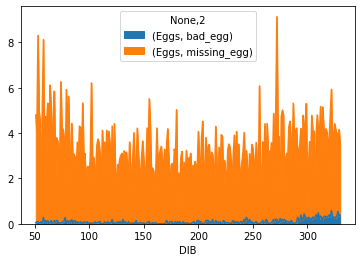

In [141]:
df['bad_egg'] = df['#eggOutsideBoxPerTier'].map(lambda x: x*100)
df_egg = pd.melt(df, id_vars=['PenID','Treatment','DIB'], value_vars=['bad_egg','missing_egg'], value_name='Eggs')
print(df_egg.shape)
display(df_egg.head(3))
df_egg['Eggs'] = df_egg['Eggs'].map(lambda x: max(x,0)) #for now, but if we use CHECK ERROR WITH AVIFORUM
df_egg = df_egg.sort_values(['Eggs'], ascending=False)
pt = pd.pivot_table(df_egg[df_egg['DIB']>50], columns=[2], index=['DIB'], values=['Eggs'])
pt.plot.area()
plt.show()

In [142]:
df_egg.sort_values(['Eggs'], ascending=False)

,PenID,Treatment,DIB,2,Eggs
3360,3,OFH,-5,missing_egg,100.0
3393,4,TRAN,0,missing_egg,100.0
3397,4,TRAN,4,missing_egg,100.0
3396,4,TRAN,3,missing_egg,100.0
3420,5,OFH,-1,missing_egg,100.0
...,...,...,...,...,...
924,6,TRAN-nonfocal,79,bad_egg,0.0
923,5,OFH,106,bad_egg,0.0
922,5,OFH,105,bad_egg,0.0
921,5,OFH,104,bad_egg,0.0


In [143]:
#before rearing start: 02-06-2020 (6 eggs I think) and 04-06-2020 (8 chicks I think)
li_epi_date = [dt.datetime(2020,6,8), dt.datetime(2020,6,15), dt.datetime(2020,6,25), 
              dt.datetime(2020,8,13), dt.datetime(2020,9,11), 
               dt.datetime(2020,10,8), dt.datetime(2020,11,23), dt.datetime(2021,2,1),
               dt.datetime(2021,4,12), dt.datetime(2021,7,26)]

## In numbers

In [144]:
print(max(df['DOA'].tolist()))
df['Treatment_allpens'] = df['Treatment'].map(lambda x: x.split('-')[0])
#sum all the death within this two months time period
df_ = df.groupby(['Treatment_allpens', 'PenID'])['Early_death'].sum().reset_index()
display(df_)
#shows stat on the sumed early death across the 2 treatments
df_.groupby(['Treatment_allpens'])['Early_death'].describe()

448


,Treatment_allpens,PenID,Early_death
0,OFH,3,18
1,OFH,5,11
2,OFH,7,9
3,OFH,9,10
4,OFH,11,17
5,TRAN,4,15
6,TRAN,6,21
7,TRAN,8,16
8,TRAN,10,13
9,TRAN,12,14


,count,mean,std,min,25%,50%,75%,max
Treatment_allpens,,,,,,,,
OFH,5.0,13.0,4.183300,9.0,10.0,11.0,17.0,18.0
TRAN,5.0,15.8,3.114482,13.0,14.0,15.0,16.0,21.0


In [3]:
(18+11+9+10+17)/144

0.4513888888888889

## In visuals

In [145]:
#small date verification
df[df['PenID']==3][['Datum','DIB']].head(50)

2,Datum,DIB
4,2020-09-24 00:00:00,-5
5,2020-09-25 00:00:00,-4
6,2020-09-26 00:00:00,-3
7,2020-09-27 00:00:00,-2
8,2020-09-28 00:00:00,-1
9,2020-09-29 00:00:00,0
10,2020-09-30 00:00:00,1
11,2020-10-01 00:00:00,2
12,2020-10-02 00:00:00,3
13,2020-10-03 00:00:00,4


In [146]:
dico_title = {'#eggPerTier':'Pens\' daily number of eggs /hens', 
              '#eggOutsideBoxPerTier': 'Pens\' daily number of eggs outside nestbox /hens', 
              'Early_death':'Pens\' daily number of early death'}

# adaptability (early days & only the 8 studied pens)

In [147]:
df_adapt = df[(df['level']>config.date_populationday) & \
              (df['level']<=config.max_date_adaptability)& \
              (df['PenID'].isin([3,4,5,8,9,10,11,12]))][['DOA','PenID','Treatment','Early_death','#eggPerTier','WOA',
                                                         '#eggOutsideBoxPerTier','DIB','level']].copy()
df_adapt.to_csv(os.path.join(path_performance_visual,'STATPerformance10pensdoa119-172.csv'), index=False, sep=';')
df_adapt = df_adapt.reset_index(drop=True) #or downgrade seaborn
print(df_adapt.shape)
df_adapt.head(3)

(432, 9)


2,DOA,PenID,Treatment,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB,level
0,119,3,OFH,0,0.0,17,0.0,1,2020-09-30
1,120,3,OFH,0,0.0,18,0.0,2,2020-10-01
2,121,3,OFH,0,0.0,18,0.0,3,2020-10-02


In [148]:
df_adapt[df_adapt['level']==dt.datetime(2020,11,13)] #time light schedule stable

2,DOA,PenID,Treatment,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB,level
198,163,3,OFH,0,1.000000,24,0.004608,45,2020-11-13
226,163,4,TRAN,0,0.949772,24,0.000000,45,2020-11-13
254,163,5,OFH,1,0.968182,24,0.000000,45,2020-11-13
282,163,8,TRAN,0,0.939252,24,0.000000,45,2020-11-13
310,163,9,OFH,0,1.036697,24,0.004587,45,2020-11-13
338,163,10,TRAN,0,0.944954,24,0.000000,45,2020-11-13
366,163,11,OFH,0,1.009174,24,0.000000,45,2020-11-13
394,163,12,TRAN,0,0.922374,24,0.004566,45,2020-11-13


2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,bad_egg,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,0.0,0,113,17,-5,0,2020-09-24,OFH,0.0,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,0.0,0,114,17,-4,0,2020-09-25,OFH,0.0,OFH


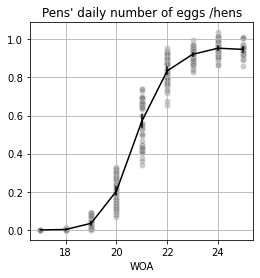

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,bad_egg,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,0.0,0,113,17,-5,0,2020-09-24,OFH,0.0,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,0.0,0,114,17,-4,0,2020-09-25,OFH,0.0,OFH


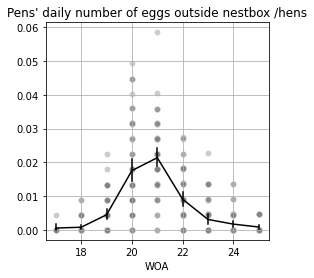

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,bad_egg,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,0.0,0.0,113,17,-5,0,2020-09-24,OFH,0.0,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,0.0,0.0,114,17,-4,0,2020-09-25,OFH,0.0,OFH


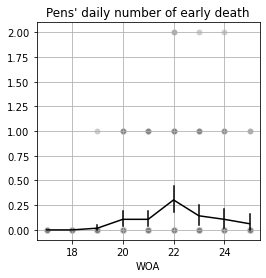

In [149]:
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(4,4))
    plt.grid()
    ax = plt.plot()
    df[v] = df[v].astype(float)
    display(df.head(2))
    sns.lineplot(x="WOA", y=v, data=df_adapt, estimator=np.mean, err_style="bars", ci=95, color='black');
    sns.scatterplot(x="WOA", y=v, data=df_adapt, alpha=0.4, color='grey');
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_WOA_adaptability.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,bad_egg,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,0.0,0.0,113,17,-5,0,2020-09-24,OFH,0.0,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,0.0,0.0,114,17,-4,0,2020-09-25,OFH,0.0,OFH


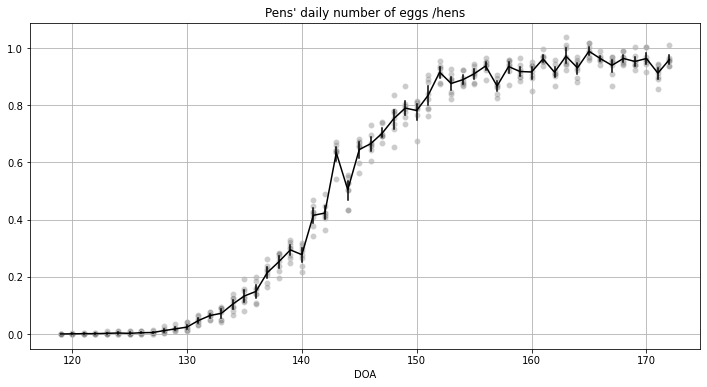

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,bad_egg,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,0.0,0.0,113,17,-5,0,2020-09-24,OFH,0.0,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,0.0,0.0,114,17,-4,0,2020-09-25,OFH,0.0,OFH


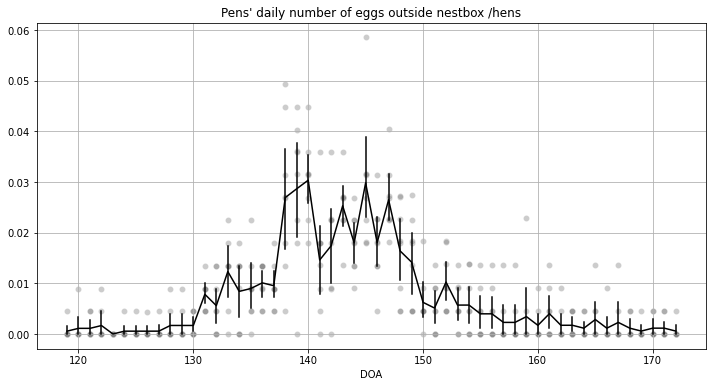

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,bad_egg,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,0,0,0,...,0.0,0.0,113,17,-5,0,2020-09-24,OFH,0.0,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,0,0,0,...,0.0,0.0,114,17,-4,0,2020-09-25,OFH,0.0,OFH


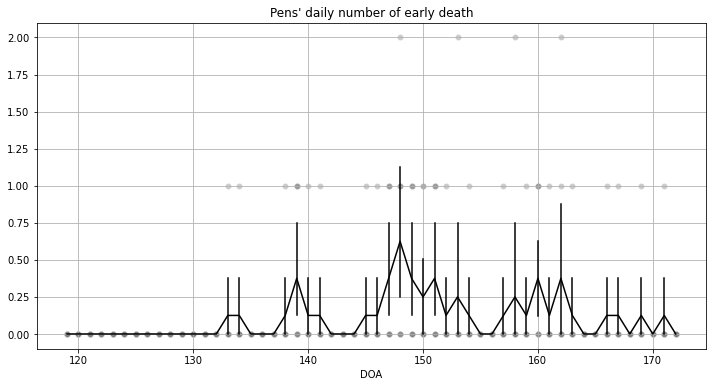

In [150]:
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(12,6))
    plt.grid()
    ax = plt.plot()
    df[v] = df[v].astype(float)
    display(df.head(2))
    sns.lineplot(x="DOA", y=v, data=df_adapt, estimator=np.mean, err_style="bars", ci=95, color='black');
    sns.scatterplot(x="DOA", y=v, data=df_adapt, alpha=0.4, color='grey');
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_DOA_adaptability.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

# All - with treatment

In [152]:
df_treatment = df[(df['level']>config.date_populationday)][['Datum','DOA','PenID','Treatment','Treatment_allpens','Early_death',
                                                            '#eggPerTier','WOA','#eggOutsideBoxPerTier','DIB']].copy()
df_treatment.to_csv(os.path.join(path_performance_visual,'STATPerformance10pensdoaallBarn4.csv'), index=False, sep=',')
df_treatment = df_treatment.reset_index() #or downgrade seaborn
print(df_treatment.shape)
df_treatment.head(3)

(3300, 11)


2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2
2,12,2020-10-02 00:00:00,121,3,OFH,OFH,0.0,0.0,18,0.0,3


In [153]:
print(df_treatment['Treatment'].unique())
print(df_treatment['Treatment_allpens'].unique())

['OFH' 'TRAN' 'TRAN-nonfocal' 'OFH-nonfocal']
['OFH' 'TRAN']


### daily or weekly

2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2


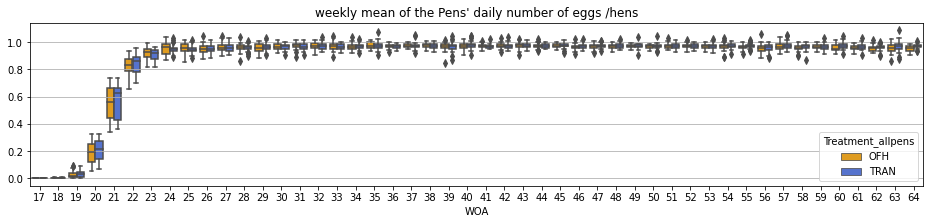

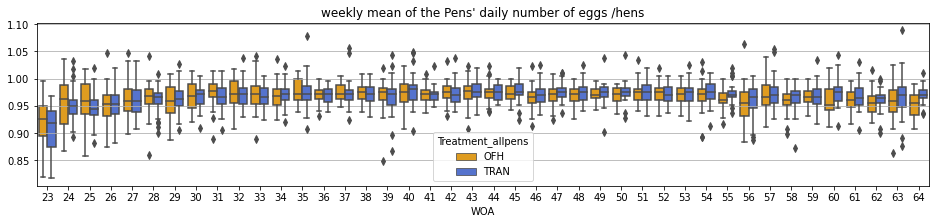

2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2


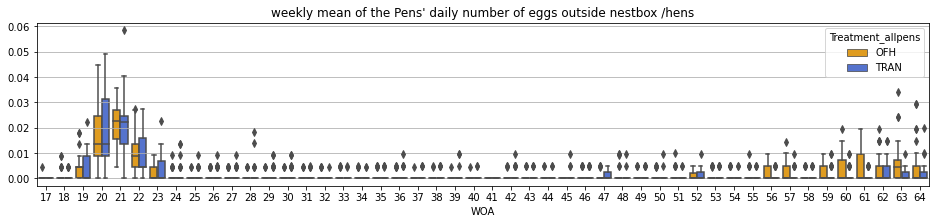

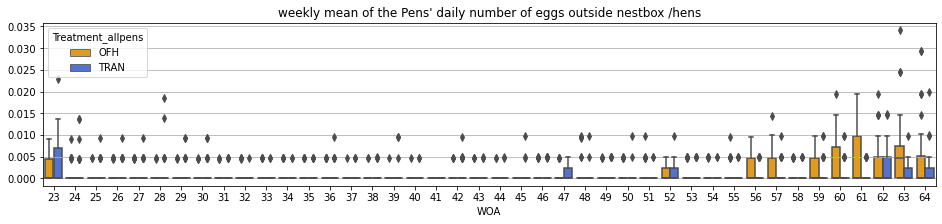

2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2


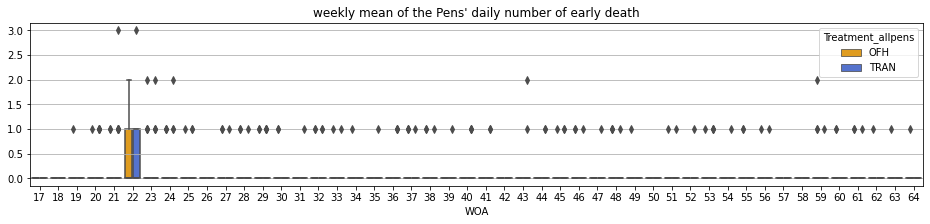

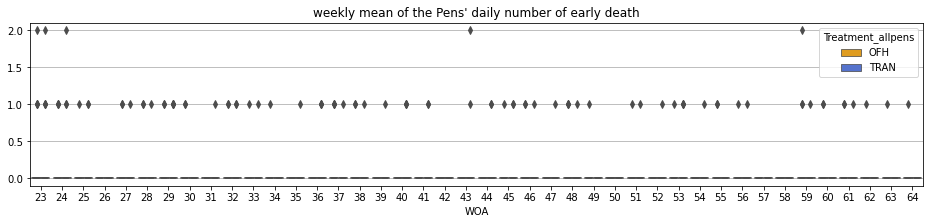

In [154]:
#just by curiosity: mean point estimate and 95 IC from boostratpping
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(16,3))
    plt.grid()
    ax = plt.plot()
    df_treatment[v] = df_treatment[v].astype(float)
    display(df_treatment.head(2))
    sns.boxplot(x="WOA", y=v, data=df_treatment, hue='Treatment_allpens', palette=pal_treat);
    #sns.lineplot(x="WOA", y=v, data=df_treatment, hue='Treatment_allpens', estimator=np.mean, err_style="bars", ci=95, 
    #             palette=pal_treat);
    #sns.scatterplot(x="WOA", y=v, data=df_treatment, hue='Treatment_allpens', alpha=0.4, palette=pal_treat);
    plt.ylabel('')
    plt.title('weekly mean of the '+dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_WOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();
    
    #only since WOA 23
    plt.figure(figsize=(16,3))
    plt.grid()
    ax = plt.plot()
    sns.boxplot(x="WOA", y=v, data=df_treatment[df_treatment['WOA']>=23], hue='Treatment_allpens', palette=pal_treat);
    plt.ylabel('')
    plt.title('weekly mean of the '+dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_WOA23_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2


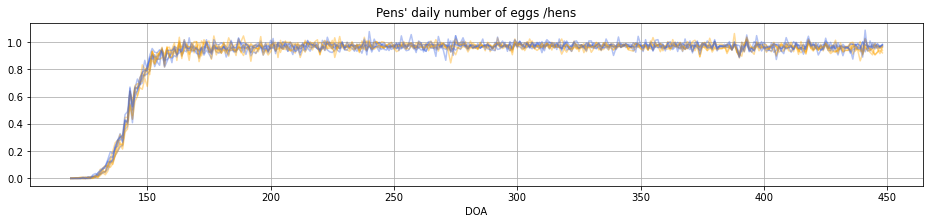

2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2


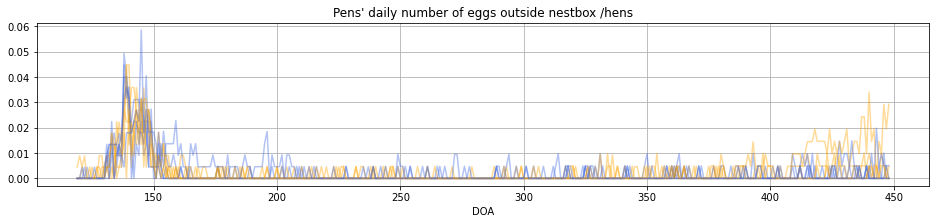

2,index,Datum,DOA,PenID,Treatment,Treatment_allpens,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB
0,10,2020-09-30 00:00:00,119,3,OFH,OFH,0.0,0.0,17,0.0,1
1,11,2020-10-01 00:00:00,120,3,OFH,OFH,0.0,0.0,18,0.0,2


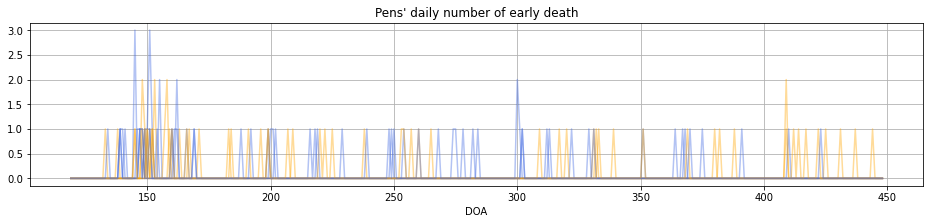

In [155]:
#per pen and per day
pal_treat_ = {3:'orange',4:'royalblue',5:'orange',6:'royalblue',7:'orange',8:'royalblue',9:'orange',
              10:'royalblue',11:'orange',12:'royalblue'}
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(16,3))
    plt.grid()
    ax = plt.plot()
    df_treatment[v] = df_treatment[v].astype(float)
    display(df_treatment.head(2))
    sns.lineplot(x="DOA", y=v, data=df_treatment, hue='PenID', alpha=0.4, palette=pal_treat_, legend=False);
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,'PenID_'+v+'_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

### cumulative

In [156]:
#look more precisely when they occured
df_treatment[df_treatment['Early_death']>0][['Datum','PenID','Treatment','Early_death','DOA']].sort_values(['DOA'])

2,Datum,PenID,Treatment,Early_death,DOA
14,2020-10-14 00:00:00,3,OFH,1.0,133
213,2020-10-15 00:00:00,12,TRAN,1.0,134
19,2020-10-19 00:00:00,3,OFH,1.0,138
130,2020-10-20 00:00:00,8,TRAN,1.0,139
174,2020-10-20 00:00:00,10,TRAN,1.0,139
...,...,...,...,...,...
3274,2021-07-31 00:00:00,12,TRAN,1.0,423
3024,2021-08-02 00:00:00,3,OFH,1.0,425
3086,2021-08-08 00:00:00,5,OFH,1.0,431
3036,2021-08-14 00:00:00,3,OFH,1.0,437


In [157]:
pal_treat_

{3: 'orange',
 4: 'royalblue',
 5: 'orange',
 6: 'royalblue',
 7: 'orange',
 8: 'royalblue',
 9: 'orange',
 10: 'royalblue',
 11: 'orange',
 12: 'royalblue'}

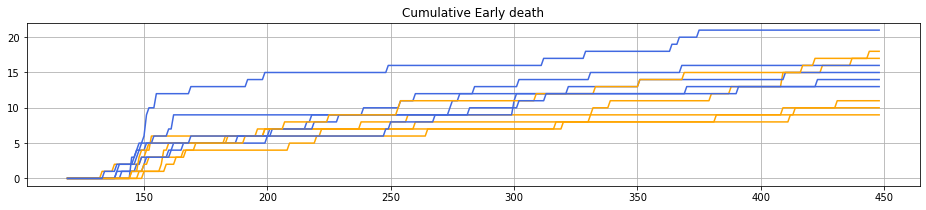

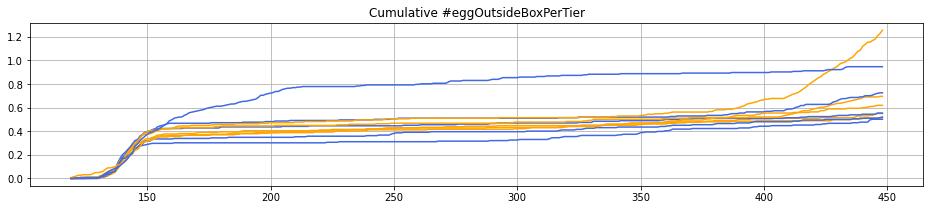

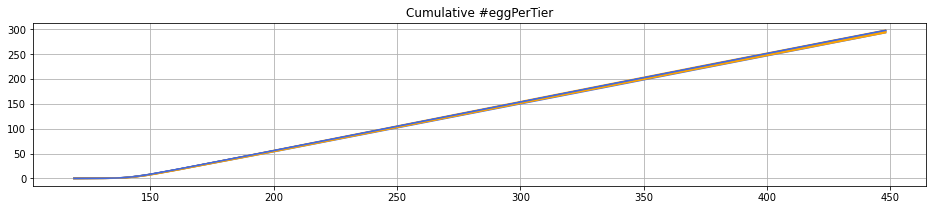

In [186]:
#per pen
for v in ['Early_death','#eggOutsideBoxPerTier', '#eggPerTier']:
    plt.figure(figsize=(16,3))
    ax = plt.plot()
    for p,df_ in df_treatment.groupby('PenID'):
        x = df_['DOA'].tolist()
        y = np.cumsum(df_[v].tolist())
        plt.plot(x, y, color=pal_treat_[p])  
    plt.title('Cumulative '+v.replace('_',' '))
    plt.grid(True)
    plt.savefig(os.path.join(path_performance_visual, 'PenID_cumulative_'+v+'_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

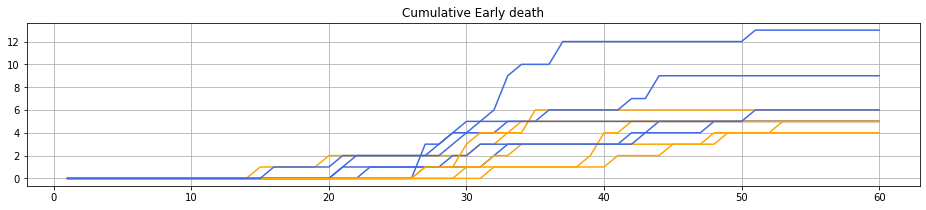

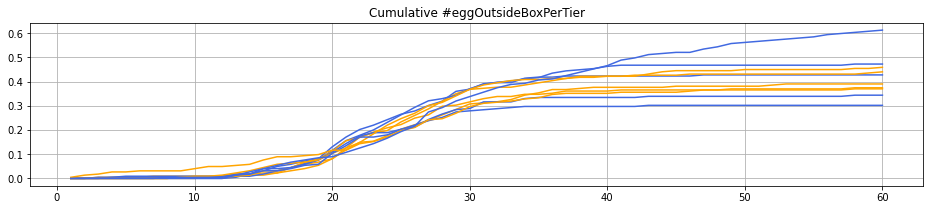

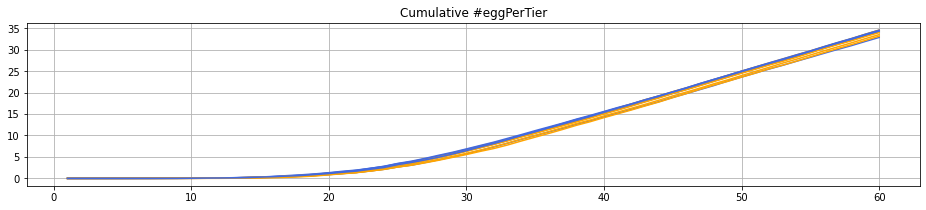

In [187]:
#per pen
for v in ['Early_death','#eggOutsideBoxPerTier', '#eggPerTier']:
    plt.figure(figsize=(16,3))
    ax = plt.plot()
    for p,df_ in df_treatment[df_treatment['DIB']<=60].groupby('PenID'):
        x = df_['DIB'].tolist()
        y = np.cumsum(df_[v].tolist())
        plt.plot(x, y, color=pal_treat_[p])  
    plt.title('Cumulative '+v.replace('_',' '))
    plt.grid(True)
    plt.savefig(os.path.join(path_performance_visual, 'PenID_cumulative_'+v+'_DIB_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

# Water

(296, 23)


,Date,Grow day,Water Consumption(Liter),Water_Count_1,Water_Count_2,Water_Count_3,Water_Count_4,Water_Count_5,Water_Count_6,Water_Count_7,...,Water_Count_11,Water_Count_12,Water_Count_13,Water_Count_14,Water_Count_15,Water_Count_16,Water_Count_17,Water_Count_18,Water_Count_19,Water_Count_20
0,2020-11-10,1,571,30.2,34.2,31.3,24.9,25.9,24.9,31.1,...,24.8,25.6,27.7,27.1,26.3,31.9,26.0,36.5,32.2,25.4
1,2020-11-11,2,1296,111.3,65.0,57.3,61.0,56.9,66.4,53.9,...,64.5,55.8,62.5,66.0,64.7,62.3,63.9,71.6,66.1,58.5
2,2020-11-12,3,928,50.9,47.7,51.3,45.0,46.0,41.8,11.4,...,45.4,47.1,50.7,51.2,49.5,50.1,48.7,51.0,48.5,47.9


,Date,variable,water consumption (l),PenID,Treatment_,Treatment,DOA,WOA,DIB,WIB,monthILB
592,2020-11-10,Water_Count_3,31.3,3,OFH,OFH,160,23,42,6,month2
593,2020-11-11,Water_Count_3,57.3,3,OFH,OFH,161,23,43,7,month2
594,2020-11-12,Water_Count_3,51.3,3,OFH,OFH,162,24,44,7,month2


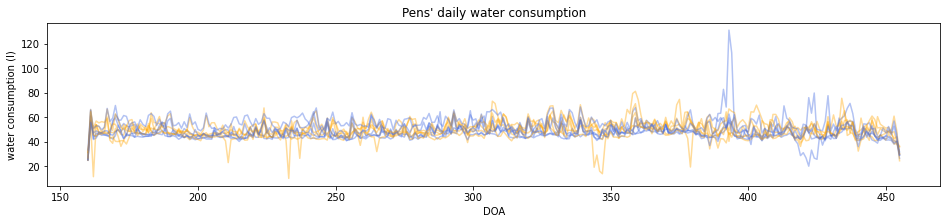

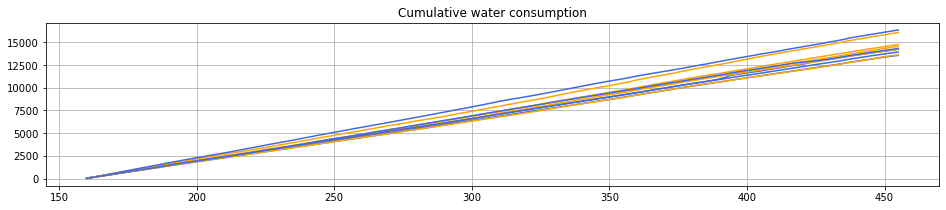

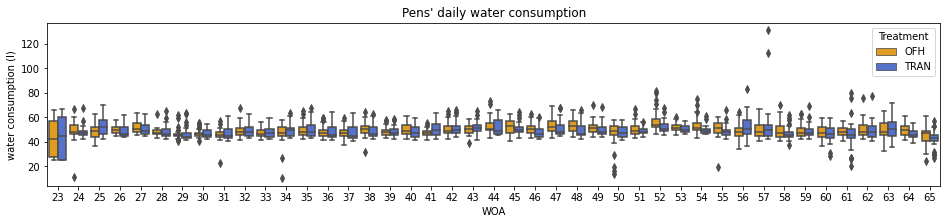

In [159]:
df_water = pd.read_excel(os.path.join(path_performance,'Water_data_E420.xlsx'),parse_dates=['Date'])
print(df_water.shape)
display(df_water.head(3))

li = [i for i in df_water.columns if "Water_Count" in i]
df_w = pd.melt(df_water, id_vars=['Date'], value_vars=li, value_name = 'water consumption (l)')
df_w['PenID'] = df_w['variable'].map(lambda x: int(x.split('_')[-1]))
df_w= df_w[df_w['PenID'].isin([3,4,5,6,7,8,9,10,11,12])].copy()
df_w['Treatment_'] = df_w['PenID'].map(lambda x: dico_pen_tr[x])
df_w['Treatment'] = df_w['Treatment_'].map(lambda x: x.split('-')[0])
df_w['DOA'] = df_w['Date'].map(lambda x: (x-birth_date).days) 
df_w['WOA'] = df_w['DOA'].map(lambda x: math.ceil(x/7))
df_w['DIB'] = df_w['DOA'].map(lambda x: x-118)
df_w['WIB'] = df_w['DIB'].map(lambda x:  math.ceil(x/7))
dico_month_ = {9:1,10:1,11:2,12:3,1:4,2:5,3:6,4:7,5:8,6:9,7:10,8:11}
df_w['monthILB'] = df_w['Date'].map(lambda x:'month'+str(dico_month_[x.month]))
display(df_w.head(3))

plt.figure(figsize=(16,3))
sns.lineplot(x="DOA", y='water consumption (l)', data=df_w, hue='PenID', alpha=0.4,  palette=pal_treat_, legend=False);
plt.title('Pens\' daily water consumption')
plt.savefig(os.path.join(path_performance_visual, 'PenID_water_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16,3))
for p,df_ in df_w.groupby('PenID'):
    x = df_['DOA'].tolist()
    y = np.cumsum(df_['water consumption (l)'].tolist())
    plt.plot(x, y, color=pal_treat_[p])  
    plt.title('Cumulative water consumption')
    plt.grid(True)
plt.savefig(os.path.join(path_performance_visual, 'PenID_water_DOA_treatment_cumulative.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()
    
    
plt.figure(figsize=(16,3))
sns.boxplot(x="WOA", y='water consumption (l)', data=df_w, hue='Treatment', palette=pal_treat)
plt.title('Pens\' daily water consumption')
plt.savefig(os.path.join(path_performance_visual, 'PenID_water_WOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

# Food

(336, 22)


,Date,Tag,Food_Count_1,Food_Count_2,Food_Count_3,Food_Count_4,Food_Count_5,Food_Count_6,Food_Count_7,Food_Count_8,...,Food_Count_11,Food_Count_12,Food_Count_13,Food_Count_14,Food_Count_15,Food_Count_16,Food_Count_17,Food_Count_18,Food_Count_19,Food_Count_20
0,2020-09-24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-09-25,2,17.1,17.0,16.7,16.8,17.0,17.0,17.4,16.8,...,17.1,17.1,17.0,16.9,17.1,17.0,16.8,16.9,16.6,16.5
2,2020-09-26,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Date,variable,food consumption (kg),PenID,Treatment_,Treatment,DOA,WOA,DIB,WIB,monthILB
672,2020-09-24,Food_Count_3,0.0,3,OFH,OFH,113,17,-5,0,month1
673,2020-09-25,Food_Count_3,16.7,3,OFH,OFH,114,17,-4,0,month1
674,2020-09-26,Food_Count_3,0.0,3,OFH,OFH,115,17,-3,0,month1


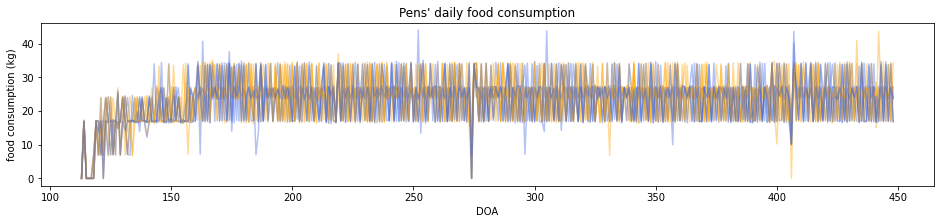

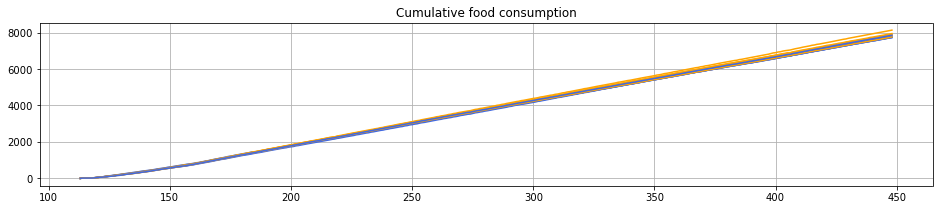

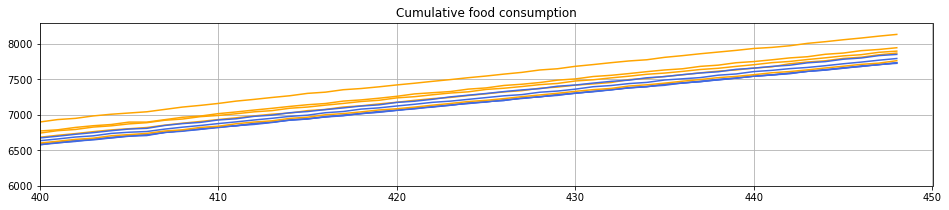

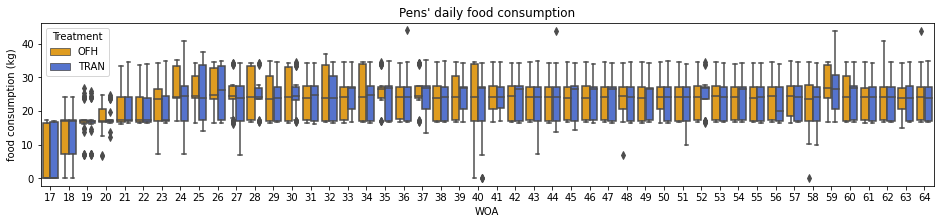

In [160]:
df_food = pd.read_csv(os.path.join(path_performance,'Food_data_E420.csv'), sep=',', parse_dates=['Date'], dayfirst=True)
print(df_food.shape)
display(df_food.head(3))

li = [i for i in df_food.columns if "Food_Count" in i]
df_f = pd.melt(df_food, id_vars=['Date'], value_vars=li, value_name = 'food consumption (kg)')
df_f['PenID'] = df_f['variable'].map(lambda x: int(x.split('_')[-1].strip()))
df_f = df_f[df_f['PenID'].isin([3,4,5,6,7,8,9,10,11,12])].copy()
df_f['Treatment_'] = df_f['PenID'].map(lambda x: dico_pen_tr[x])
df_f['Treatment'] = df_f['Treatment_'].map(lambda x: x.split('-')[0])
df_f['DOA'] = df_f['Date'].map(lambda x: (x-birth_date).days) 
df_f['WOA'] = df_f['DOA'].map(lambda x: math.ceil(x/7))
df_f['DIB'] = df_f['DOA'].map(lambda x: x-118)
df_f['WIB'] = df_f['DIB'].map(lambda x:  math.ceil(x/7))
dico_month_ = {9:1,10:1,11:2,12:3,1:4,2:5,3:6,4:7,5:8,6:9,7:10,8:11}
df_f['monthILB'] = df_f['Date'].map(lambda x:'month'+str(dico_month_[x.month]))
display(df_f.head(3))

plt.figure(figsize=(16,3))
sns.lineplot(x="DOA", y='food consumption (kg)', data=df_f, hue='PenID', alpha=0.4,  palette=pal_treat_, legend=False);
plt.title('Pens\' daily food consumption')
plt.savefig(os.path.join(path_performance_visual, 'PenID_food_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16,3))
for p,df_ in df_f.groupby('PenID'):
    x = df_['DOA'].tolist()
    y = np.cumsum(df_['food consumption (kg)'].tolist())
    plt.plot(x, y, color=pal_treat_[p])  
    plt.title('Cumulative food consumption')
    plt.grid(True)
plt.savefig(os.path.join(path_performance_visual, 'PenID_food_DOA_treatment_cumulative.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16,3))
for p,df_ in df_f.groupby('PenID'):
    x = df_['DOA'].tolist()
    y = np.cumsum(df_['food consumption (kg)'].tolist())
    plt.plot(x, y, color=pal_treat_[p])  
    plt.title('Cumulative food consumption')
    plt.xlim((400,450))
    plt.ylim((6000,8300))
    plt.grid(True)
plt.show()

plt.figure(figsize=(16,3))
sns.boxplot(x="WOA", y='food consumption (kg)', data=df_f, hue='Treatment', palette=pal_treat)
plt.title('Pens\' daily food consumption')
plt.savefig(os.path.join(path_performance_visual, 'PenID_food_WOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

In [161]:
#savw daily egg
df.rename(columns={'level':'Date'}, inplace=True)
df[['PenID','Treatment','Date','DIB','WIB','Tier-bestand',
    '#eggOutsideBoxPerTier','#eggPerTier','Treatment_allpens','Early_death']].to_csv(os.path.join(path_extracted_data,'df_eggdata.csv'), index=False, sep=',')

In [162]:
df['Early_death'].value_counts()

0.0    3227
1.0     124
2.0       7
3.0       2
Name: Early_death, dtype: int64